# Finite Difference bond

Bond pricing through finite difference and comparison with analytic expression

In [ ]:
import os
import sys

In [5]:
current_dir = os.getcwd()
qg_dir = os.path.join(current_dir, "..")

sys.path.append(qg_dir)

In [6]:
import numpy as np
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
matplotlib.rcParams['text.usetex'] = True
from quassigaussian.finitedifference.mesher.linear_mesher import extract_x0_result


In [42]:
from quassigaussian.finitedifference.adi.run_adi import AdiRunner
from quassigaussian.parameters.volatility.local_volatility import LinearLocalVolatility
from quassigaussian.products.instruments import Bond
from quassigaussian.products.instruments import Swap, Swaption
from quassigaussian.products.pricer import SwapPricer, SwaptionPricer, find_implied_black_vola

from quassigaussian.products.pricer import BondPricer
from quassigaussian.finitedifference.mesher.grid_boundaries import calculate_x_boundaries2, calculate_u_boundaries, calculate_x_boundaries3
from quassigaussian.finitedifference.mesher.linear_mesher import Mesher2d
import pandas as pd
import os
from qgtests.utis import get_mock_yield_curve_const

### Market Parameters

In [65]:
maturity = 30
curve_rate = 0.01
maturity= 30
kappa = 0.03
theta = 1/2
initial_curve = get_mock_yield_curve_const(rate=curve_rate)

loca_vola = LinearLocalVolatility.from_const(maturity, 0.4, 0.01, 0.1)
t_max = maturity
t_min = 0

#### Setting up Adi Runner and Grid

In [66]:
t_grid_size = 100
x_grid_size = 150
u_grid_size = 20


x_min, x_max = calculate_x_boundaries3(t_max, kappa, loca_vola, alpha=3)
u_min, u_max = calculate_u_boundaries(t_max, kappa, loca_vola, alpha=4)

mesher = Mesher2d()
mesher.create_mesher_2d(t_min, t_max, t_grid_size, x_min, x_max, x_grid_size, u_min, u_max,
                        u_grid_size)


In [67]:
adi_runner = AdiRunner(theta, kappa, initial_curve, loca_vola, mesher)


## Pricing Bond with ADI

In [68]:
bond = Bond(maturity)
bond_pricer = BondPricer(initial_curve, kappa)


In [69]:
fd_bond = pd.DataFrame(adi_runner.run_adi(bond, bond_pricer))


29.6969696969697
29.393939393939394
29.090909090909093
28.78787878787879
28.484848484848484
28.181818181818183
27.87878787878788
27.575757575757578
27.272727272727273
26.96969696969697
26.666666666666668
26.363636363636363
26.060606060606062
25.757575757575758
25.454545454545457
25.151515151515152
24.848484848484848
24.545454545454547
24.242424242424242
23.93939393939394
23.636363636363637
23.333333333333336
23.03030303030303
22.727272727272727
22.424242424242426
22.12121212121212
21.81818181818182
21.515151515151516
21.21212121212121
20.90909090909091
20.606060606060606
20.303030303030305
20.0
19.6969696969697
19.393939393939394
19.09090909090909
18.78787878787879
18.484848484848484
18.181818181818183
17.87878787878788
17.575757575757578
17.272727272727273
16.96969696969697
16.666666666666668
16.363636363636363
16.060606060606062
15.757575757575758
15.454545454545455
15.151515151515152
14.84848484848485
14.545454545454547
14.242424242424242
13.93939393939394
13.636363636363637
13.3333

#### Compare Bond Value with accurate pricer

In [70]:
y_bar = 0 #y_bar=0 at t=0
bond_pricer = BondPricer(initial_curve, kappa)
bond_value_analytics = bond_pricer.price(bond, mesher.xmesh, mesher.umesh + y_bar, 0)


In [71]:
bond_value_analytics

array([[1.67450238, 1.67431906, 1.67413575, ..., 1.67157159, 1.67138859,
        1.6712056 ],
       [1.65485144, 1.65467027, 1.65448912, ..., 1.65195505, 1.65177419,
        1.65159336],
       [1.63543112, 1.63525207, 1.63507304, ..., 1.63256871, 1.63238998,
        1.63221127],
       ...,
       [0.29182727, 0.29179532, 0.29176337, ..., 0.2913165 , 0.2912846 ,
        0.29125271],
       [0.28840256, 0.28837099, 0.28833941, ..., 0.28789778, 0.28786627,
        0.28783475],
       [0.28501804, 0.28498684, 0.28495564, ..., 0.28451919, 0.28448804,
        0.2844569 ]])

In [72]:
xgrid = mesher.xgrid
ugrid = mesher.ugrid
x0_pos = np.where(xgrid == 0)[0][0]
u0_pos = np.where(ugrid == 0)[0][0]

xgrid_plot = (xgrid[0]>=-0.025) & (xgrid[0]<=0.025)


In [73]:
def plot_bond_price_for_different(grid, output_fd, bond_value, grid_dir="x"):

    fig, ax1 = plt.subplots()
    ax1.plot(grid, bond_value, "b--", label="Exact formula")
    ax1.plot(grid, output_fd, "rx", label="Finite difference", markersize=2.5)

    error = (output_fd-bond_value)/bond_value * 10000
    ax1.set_xlabel(grid_dir + " value")

    ax2 = ax1.twinx()
    ax2.plot(grid, error, "kd", label="Error", markersize=3)

    ax2.set_ylabel("Error in bond value (bps)")

    if (grid_dir=="x"):
        lgnd = ax1.legend(loc="upper center")
    else:
        lgnd = ax1.legend(loc="lower center")

    lgnd.legendHandles[0]._legmarker.set_markersize(6)
    lgnd.legendHandles[1]._legmarker.set_markersize(6)


    ax2.legend(loc="upper right")
    #ax1.set_title(title)
    return fig

In [74]:
xgrid_plot = (xgrid>=-0.025) & (xgrid<=0.025)


Text(0, 0.5, 'Bond Value')

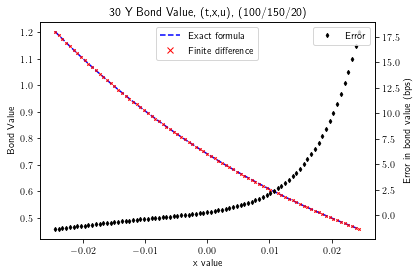

In [75]:
fig = plot_bond_price_for_different(xgrid[xgrid_plot], fd_bond.loc[xgrid_plot, u0_pos], bond_value_analytics[xgrid_plot, u0_pos], "x")
ax = fig.axes[0]
ax.set_title("30 Y Bond Value, (t,x,u), (100/150/20)")
ax.set_ylabel("Bond Value")